In [4]:
import MDAnalysis
import openmm 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import parmed
import glob
import pickle
import numpy as np

In [54]:
af_file_dir = "/gpfs/alpine/world-shared/bif135/alphafold_onsummit/alphafold_test/casp14/af_reduced_db/"
af_pkl_files = glob.glob(af_file_dir+"*/result*.pkl")
unrefined_model_files = glob.glob(af_file_dir+"*/unrelaxed_model_*.pdb")

### OPENMM GPU PLATFORM 
refined_model_files = glob.glob(af_file_dir+"*/model*_min_00.pdb")
refined_log_files = glob.glob(af_file_dir+"*/model*.log")
output_dir = "/gpfs/alpine/proj-shared/bip198/minimize_af/script_home/casp14_refinement2/"
### OPENMM CPU PLATFORM
#refined_model_files = glob.glob(af_file_dir+"*/cpu_relaxation/model*_min_00.pdb")
#refined_log_files = glob.glob(af_file_dir+"*/cpu_relaxation/model*.log")
#output_dir = "/gpfs/alpine/proj-shared/bip198/minimize_af/cpu_pipeline/"

In [55]:
af_pkl_files.sort()
unrefined_model_files.sort()
refined_model_files.sort()
refined_log_files.sort()
print(len(af_pkl_files), len(unrefined_model_files), len(refined_model_files),len(refined_log_files))

160 160 160 160


In [56]:
#print(af_pkl_files[0])
#pkl_file = pickle.load(open(af_pkl_files[0],'rb'))
#pkl_file

In [57]:
### STRUCTURAL ANALYSIS
#print(unrefined_model_files[0])
#unrefined_model = MDAnalysis.Universe(unrefined_model_files[0])
#protein = unrefined_model.select_atoms('protein and name CA')
#print(protein.n_atoms)

In [58]:
#print(refined_model_files[0])
#refined_model = MDAnalysis.Universe(refined_model_files[0])
#protein_refined = refined_model.select_atoms('protein and name CA')
#print(protein_refined.n_atoms)

In [59]:
## NGLVIEW ISN'T WORKING
#import nglview as nv
#print("nglview version = {}".format(nv.__version__))
#b = nv.show_mdanalysis(protein)
#b.clear()
#b.add_cartoon('protein',color='blue')
#b

In [60]:
#import time
#time.time()

In [61]:
with open(refined_log_files[0],'r') as test:
    timings = []
    energies = []
    for line in test:
        print(line.split('INFO')[1].rstrip())
        if 'Finished' in line:
            timings.append(line.split()[-2])
        elif 'Starting energy' in line:
            energies.append(line.split()[-3])
        elif 'Final energy' in line:
            energies.append(line.split()[-3])
        elif 'dE' in line:
            energies.append(line.split()[-3])

print(timings)
print(energies)
print(len(refined_log_files))

       Checking model for any required fixes (missing hydrogens and other atoms, etc).
               Loading /gpfs/alpine/world-shared/bif135/alphafold_onsummit/alphafold_test/casp14/af_reduced_db/T1027/unrelaxed_model_1.pdb to check for missing atoms and add hydrogens.
               Saving /gpfs/alpine/world-shared/bif135/alphafold_onsummit/alphafold_test/casp14/af_reduced_db/T1027/model_1_protonated.pdb.
       Finished preparing the protein model for minimization; took 8.221072912216187 secs.
       Preparing the simulation engine:
               Loading /gpfs/alpine/world-shared/bif135/alphafold_onsummit/alphafold_test/casp14/af_reduced_db/T1027/model_1_protonated.pdb to create the OpenMM simulation object.
               Using amber99sb.xml.
               Building HBond constraints as well as restraints on non_hydrogen.
               Creating the OpenMM simulation object.
       Finished preparing the simulation engine; took 1.6163246631622314 secs.
       Running the minimiza

In [62]:
timings = np.zeros((len(refined_log_files),3))
energies = np.zeros((len(refined_log_files),3))
for i, log_file in enumerate(refined_log_files):
    with open(log_file,'r') as test:
        temp_timings = []
        temp_energies = []
        for line in test:
            #print(line.split('INFO')[1].rstrip())
            if 'Finished' in line:
                temp_timings.append(float(line.split()[-2]))
            elif 'Starting energy' in line:
                temp_energies.append(float(line.split()[-3]))
                #if float(line.split()[-3]) > 10**6:
                    #print(log_file,float(line.split()[-3]))
            elif 'Final energy' in line:
                temp_energies.append(float(line.split()[-3]))
                #if float(line.split()[-3]) > 10**6:
                    #print(log_file,float(line.split()[-3]))
            elif 'dE' in line:
                temp_energies.append(float(line.split()[-3]))
                #if float(line.split()[-3]) > 0:
                    #print(log_file,float(line.split()[-3]))
    timings[i] = temp_timings
    energies[i] = temp_energies

mean = np.mean(timings,axis=0)
med  = np.median(timings,axis=0)
max_ = np.max(timings,axis=0)
min_ = np.min(timings,axis=0)
std  = np.std(timings,axis=0)

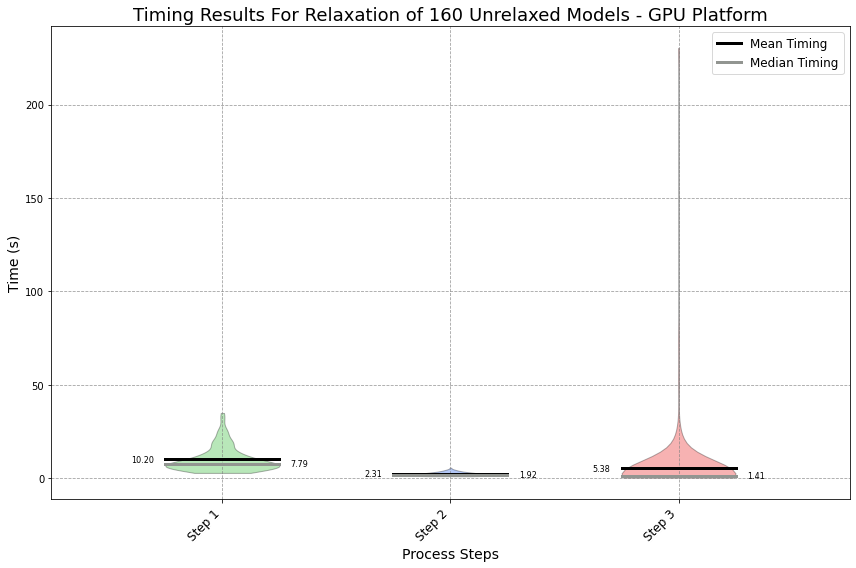

In [63]:
fig1 = plt.figure(1,figsize=(12,8))
ax = plt.gca()
#ax.set_title('Timing Results For Relaxation of %s Unrelaxed Models - CPU Platform' %(timings.shape[0]),size=18)
ax.set_title('Timing Results For Relaxation of %s Unrelaxed Models - GPU Platform' %(timings.shape[0]),size=18)

ax.set_ylabel('Time (s)',size=14)
ax.set_xlabel('Process Steps',size=14)
ax.get_xaxis().set_tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x',which='major',labelsize=8)
#ax.set_ylim(0, np.max(timings)+np.max(timings)*0.01)
#ax.set_ylim((-1, 40))

custom_lines = [Line2D([0],[0],color='xkcd:black',lw=3),Line2D([0],[0],color='xkcd:grey',lw=3)]
parts = ax.violinplot(timings,showextrema=False)

nSteps = timings.shape[1]
for step in range(nSteps):
    ax.text(step+1 - 0.30, mean[step],'%.2f'%(mean[step]),fontsize=8,horizontalalignment='right',verticalalignment='center')
    ax.text(step+1 + 0.30, med[step], '%.2f'%(med[step]) ,fontsize=8,horizontalalignment='left',verticalalignment='center')
    ax.plot([step+1-0.25,step+1+0.25],[mean[step],mean[step]],'xkcd:black',lw=3)
    ax.plot([step+1-0.25,step+1+0.25],[med[step],med[step]],'xkcd:grey',lw=3)
ax.set_xticks(np.arange(1,4))
ax.set_xticklabels(['Step 1','Step 2','Step 3'],rotation='45',ha='right',fontsize=12)
ax.set_xlim(0.25,3.75)
parts['bodies'][0].set_facecolor('xkcd:green')
parts['bodies'][1].set_facecolor('xkcd:blue')
parts['bodies'][2].set_facecolor('xkcd:red')
for pc in parts['bodies']:
    pc.set_edgecolor('black')

ax.legend(custom_lines,['Mean Timing','Median Timing'],fontsize=12,loc=1,fancybox=True,framealpha=0.75)
plt.grid(b=True,which='major',axis='both',color='#808080',linestyle='--',alpha=0.75)
plt.tight_layout()
plt.savefig(output_dir + 'timing_violin_plt.png',dpi=600,transparent=True)
plt.show()

In [64]:
plt.close(fig1)

### Parse AF timing data; need seperate code for this

In [66]:
af_file_dir = "/gpfs/alpine/world-shared/bif135/alphafold_onsummit/alphafold_test/casp14/af_reduced_db/"
af_pkl_files = glob.glob(af_file_dir+"*/result*.pkl")
unrefined_model_files = glob.glob(af_file_dir+"*/unrelaxed_model_*.pdb")
# AF OPENMM MINIMIZATION PROTOCOL AND CPU PLATFORM
refined_model_files = glob.glob(af_file_dir+"*/relaxed_model*.pdb")
refined_log_files = glob.glob(af_file_dir+"*/timings_str.json")
output_dir = "/gpfs/alpine/proj-shared/bip198/minimize_af/cpu_pipeline/"

In [67]:
af_pkl_files.sort()
unrefined_model_files.sort()
refined_model_files.sort()
refined_log_files.sort()
print(len(af_pkl_files), len(unrefined_model_files), len(refined_model_files),len(refined_log_files))

160 160 160 32


In [68]:
timings = []
for i, log_file in enumerate(refined_log_files):
    with open(log_file,'r') as test:
        temp_timings = []
        for line in test:
            if 'relax_model' in line:
                temp_timings.append(float(line.split()[-1][:-1]))
        timings += temp_timings
mean = np.mean(timings)
med  = np.median(timings)
max_ = np.max(timings)
min_ = np.min(timings)
std  = np.std(timings)

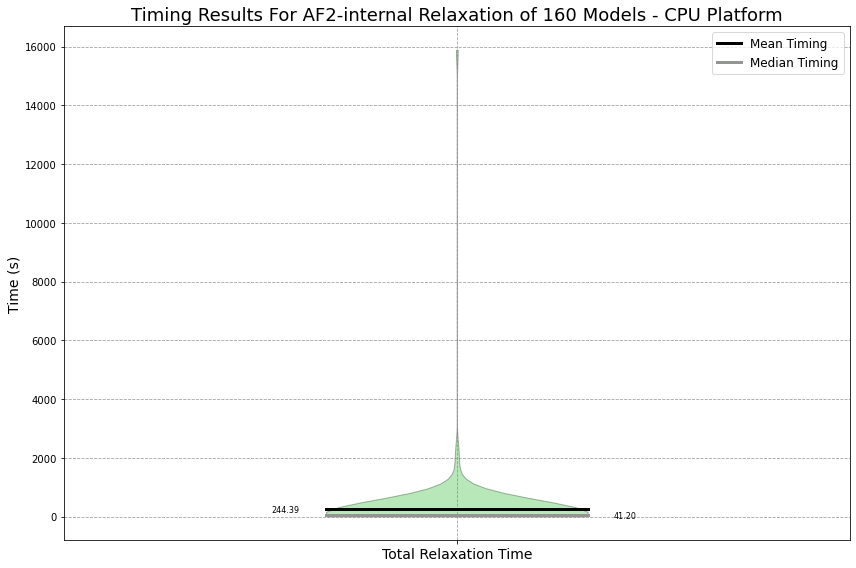

In [71]:
fig1 = plt.figure(1,figsize=(12,8))
ax = plt.gca()
#ax.set_title('Timing Results For Relaxation of %s Unrelaxed Models - CPU Platform' %(timings.shape[0]),size=18)
ax.set_title('Timing Results For AF2-internal Relaxation of %s Models - CPU Platform' %(len(timings)),size=18)

ax.set_ylabel('Time (s)',size=14)
#ax.set_xlabel('Process Steps',size=14)
ax.get_xaxis().set_tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x',which='major',labelsize=8)
#ax.set_ylim(0, np.max(timings)+np.max(timings)*0.01)
#ax.set_ylim((-1, 40))

custom_lines = [Line2D([0],[0],color='xkcd:black',lw=3),Line2D([0],[0],color='xkcd:grey',lw=3)]
parts = ax.violinplot(timings,showextrema=False)

ax.text(1 - 0.30, mean,'%.2f'%(mean),fontsize=8,horizontalalignment='right',verticalalignment='center')
ax.text(1 + 0.30, med, '%.2f'%(med) ,fontsize=8,horizontalalignment='left',verticalalignment='center')
ax.plot([1-0.25,1+0.25],[mean,mean],'xkcd:black',lw=3)
ax.plot([1-0.25,1+0.25],[med,med],'xkcd:grey',lw=3)
ax.set_xticks(np.arange(1,4))
ax.set_xticklabels(['Total Relaxation Time'],ha='center',fontsize=14)
ax.set_xlim(0.25,1.75)
parts['bodies'][0].set_facecolor('xkcd:green')
for pc in parts['bodies']:
    pc.set_edgecolor('black')

ax.legend(custom_lines,['Mean Timing','Median Timing'],fontsize=12,loc=1,fancybox=True,framealpha=0.75)
plt.grid(b=True,which='major',axis='both',color='#808080',linestyle='--',alpha=0.75)
plt.tight_layout()
plt.savefig(output_dir + 'af2_timing_violin_plt.png',dpi=600,transparent=True)
plt.show()

In [72]:
plt.close(fig1)

### COMPARE ENERGIES OF UNRELAXED TO RELAXED MODELS FOR ALL PLATFORMS TO DEMONSTRATE THAT THEY RECOVER EQUIVALENT ENERGETIC STRUCTURES
### COMPARE RELAXED STRUCTURES TO KNOWN CRYSTAL STRUCTURE TO DEMONSTRATE THAT THESE METHODS RECOVER EQUIVALENT QUALITY OF RELAXED MODEL